# 보스턴 집값 예측하기 - 다중선형

## #01. 패키지

In [1]:
import sys
sys.path.append("../../")
import helper

from pandas import read_excel, DataFrame, merge
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## #02. 데이터셋 준비

In [2]:
origin = read_excel("https://data.hossam.kr/E04/boston.xlsx")
origin.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,CAT. MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0,0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6,0
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7,1
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4,1
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2,1


In [3]:
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   CRIM       506 non-null    float64
 1   ZN         506 non-null    float64
 2   INDUS      506 non-null    float64
 3   CHAS       506 non-null    int64  
 4   NOX        506 non-null    float64
 5   RM         506 non-null    float64
 6   AGE        506 non-null    float64
 7   DIS        506 non-null    float64
 8   RAD        506 non-null    int64  
 9   TAX        506 non-null    int64  
 10  PTRATIO    506 non-null    float64
 11  B          506 non-null    float64
 12  LSTAT      506 non-null    float64
 13  MEDV       506 non-null    float64
 14  CAT. MEDV  506 non-null    int64  
dtypes: float64(11), int64(4)
memory usage: 59.4 KB


## #03. 데이터 전처리

### 결측치

In [4]:
origin.isna().sum()

CRIM         0
ZN           0
INDUS        0
CHAS         0
NOX          0
RM           0
AGE          0
DIS          0
RAD          0
TAX          0
PTRATIO      0
B            0
LSTAT        0
MEDV         0
CAT. MEDV    0
dtype: int64

## #04. 탐색적 데이터 분석

### 명목형 처리

>명목형으로 의심되면 일단 value_counts()로 확인

>type, shape, info 등을 사용해 객체 형태 및 정보를 확인 가능

In [5]:
# origin['CHAS'].value_counts()
# origin['RAD'].value_counts()
origin['CAT. MEDV'].value_counts()

CAT. MEDV
0    422
1     84
Name: count, dtype: int64

In [6]:
origin['CHAS'] = origin['CHAS'].astype('category')
origin['CAT. MEDV'] = origin['CAT. MEDV'].astype('category')
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   CRIM       506 non-null    float64 
 1   ZN         506 non-null    float64 
 2   INDUS      506 non-null    float64 
 3   CHAS       506 non-null    category
 4   NOX        506 non-null    float64 
 5   RM         506 non-null    float64 
 6   AGE        506 non-null    float64 
 7   DIS        506 non-null    float64 
 8   RAD        506 non-null    int64   
 9   TAX        506 non-null    int64   
 10  PTRATIO    506 non-null    float64 
 11  B          506 non-null    float64 
 12  LSTAT      506 non-null    float64 
 13  MEDV       506 non-null    float64 
 14  CAT. MEDV  506 non-null    category
dtypes: category(2), float64(11), int64(2)
memory usage: 52.7 KB


### 기본(기초)통계 확인

describe

In [7]:
origin.describe()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


### boxplot

표준화 여부 결정 - boxplot

각 변수의 분포가 너무 상이할 경우 표준화 진행

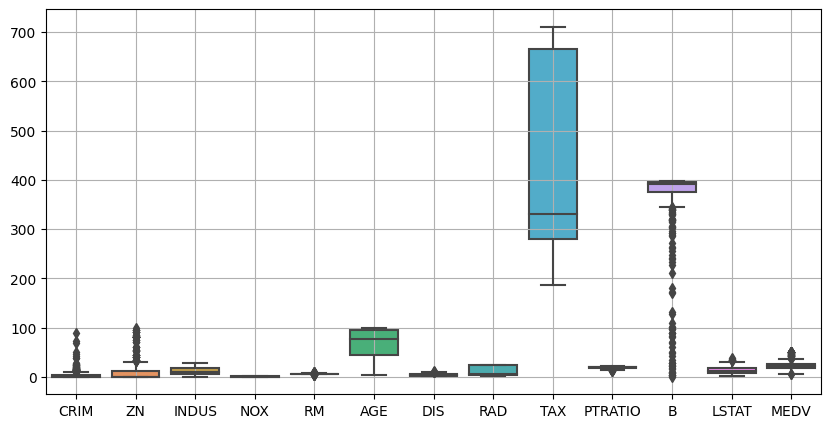

In [8]:
plt.figure(figsize=(10,5))
sb.boxplot(data=origin)
plt.grid()
plt.show()
plt.close()

### 산점도 그래프와 추세선 확인

In [9]:
# plt.figure(figsize=(30, 30))
# sb.pairplot(origin)
# plt.show()
# plt.close()

### 상관계수 확인

산점도만으로 데이터 파악이 힘들 경우 상관계수, 히트맵을 확인(종속변수 제거 후 실행)

In [10]:
corr = origin.drop('MEDV', axis=1).corr()
corr

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,CAT. MEDV
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.151987
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.365296
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.366276
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.108631
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.232502
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.641265
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.191196
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.118887
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.197924
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.273687


### 히트맵

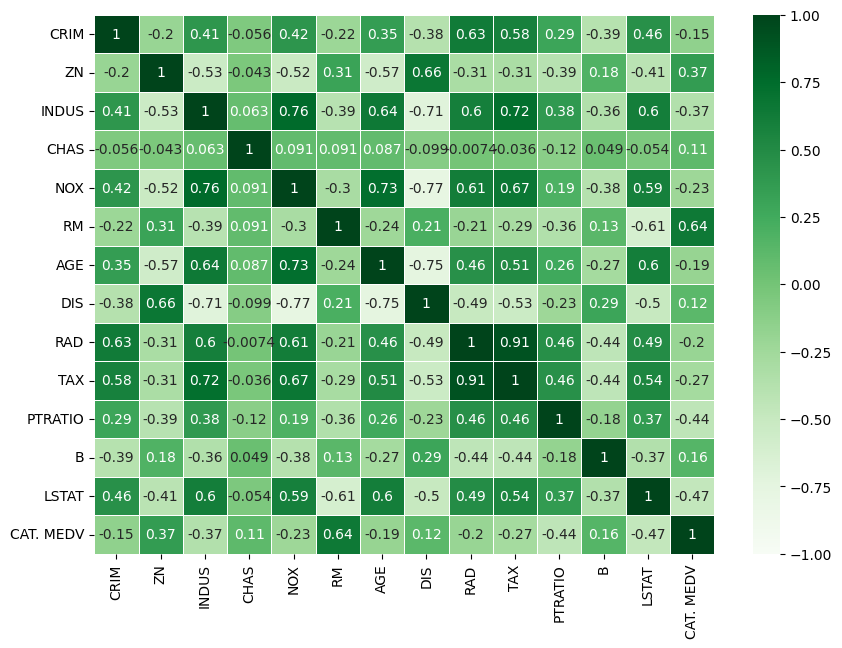

In [11]:
plt.figure(figsize=(10,7))
sb.heatmap(corr, annot = True, cmap = 'Greens', vmin = -1, vmax=1, linewidths=.5)
plt.show()
plt.close()

### 제외하기로 한 독립변수 제거

> 상관계수의 절대값이 `0.7`이상인 항목을 순차적으로 제거하여 회귀분석에 사용할 요인을 선정

상관성은 절댓값` 0.2, 0.5, 0.7`을 기준 - 데이터마다 상이하긴 함

>상관관계가 높다고 무조건 제외하는 것이 아닌 인과 관계를 파악 후 제외/존속 여부를 결정

In [12]:
x = origin.drop(['TAX','DIS', 'NOX','INDUS'], axis=1)
x

,CRIM,ZN,CHAS,RM,AGE,RAD,PTRATIO,B,LSTAT,MEDV,CAT. MEDV
0,0.00632,18.0,0,6.575,65.2,1,15.3,396.90,4.98,24.0,0
1,0.02731,0.0,0,6.421,78.9,2,17.8,396.90,9.14,21.6,0
2,0.02729,0.0,0,7.185,61.1,2,17.8,392.83,4.03,34.7,1
3,0.03237,0.0,0,6.998,45.8,3,18.7,394.63,2.94,33.4,1
4,0.06905,0.0,0,7.147,54.2,3,18.7,396.90,5.33,36.2,1
...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,0,6.593,69.1,1,21.0,391.99,9.67,22.4,0
502,0.04527,0.0,0,6.120,76.7,1,21.0,396.90,9.08,20.6,0
503,0.06076,0.0,0,6.976,91.0,1,21.0,396.90,5.64,23.9,0
504,0.10959,0.0,0,6.794,89.3,1,21.0,393.45,6.48,22.0,0


### 변수 제거후 히트맵 확인

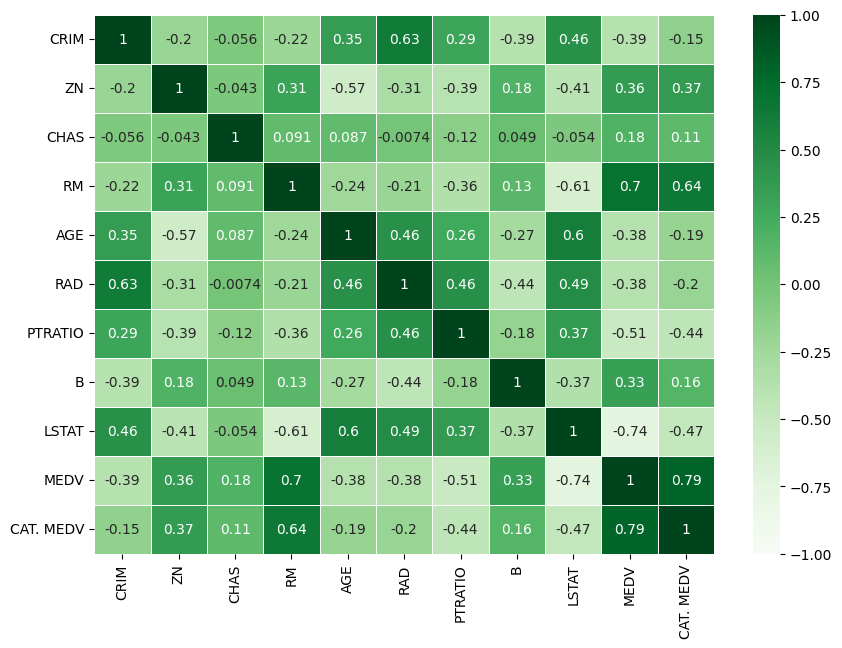

In [13]:
plt.figure(figsize=(10,7))
sb.heatmap(x.corr(), annot = True, cmap = 'Greens', vmin = -1, vmax=1, linewidths=.5)
plt.show()
plt.close()

In [14]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   CRIM       506 non-null    float64 
 1   ZN         506 non-null    float64 
 2   CHAS       506 non-null    category
 3   RM         506 non-null    float64 
 4   AGE        506 non-null    float64 
 5   RAD        506 non-null    int64   
 6   PTRATIO    506 non-null    float64 
 7   B          506 non-null    float64 
 8   LSTAT      506 non-null    float64 
 9   MEDV       506 non-null    float64 
 10  CAT. MEDV  506 non-null    category
dtypes: category(2), float64(8), int64(1)
memory usage: 36.9 KB


### 명목형 변수만 추출

In [15]:
categorical_df = x.filter(['CHAS', 'CAT. MEDV'])
categorical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   CHAS       506 non-null    category
 1   CAT. MEDV  506 non-null    category
dtypes: category(2)
memory usage: 1.4 KB


### 종속변수만 추출

In [16]:
y = x['MEDV']
y

0      24.0
1      21.6
2      34.7
3      33.4
4      36.2
       ... 
501    22.4
502    20.6
503    23.9
504    22.0
505    11.9
Name: MEDV, Length: 506, dtype: float64

### 데이터프레임에서 추출한 필드를 제거

In [17]:
x.drop(['CHAS', 'CAT. MEDV', 'MEDV'], axis=1, inplace=True)
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   RM       506 non-null    float64
 3   AGE      506 non-null    float64
 4   RAD      506 non-null    int64  
 5   PTRATIO  506 non-null    float64
 6   B        506 non-null    float64
 7   LSTAT    506 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 31.8 KB


### 최종 산점도 행렬 확인 또는 히트맵

In [18]:
# plt.figure(figsize=(30, 30))
# sb.pairplot(x)
# plt.show()
# # plt.savefig("pairplot.png")   #파일과 동일한 위치에 이미지 저장
# plt.close()

## #05. 데이터셋 분할하기

### 랜덤시드 고정

In [19]:
np.random.seed(777)

### 데이터 표준화

표준화 후 다항식 변환을 진행 - 성능 차이 발생

In [20]:
x_scaller = StandardScaler()
x_scale = x_scaller.fit_transform(x)
x_scale

array([[-0.41978194,  0.28482986,  0.41367189, ..., -1.45900038,
         0.44105193, -1.0755623 ],
       [-0.41733926, -0.48772236,  0.19427445, ..., -0.30309415,
         0.44105193, -0.49243937],
       [-0.41734159, -0.48772236,  1.28271368, ..., -0.30309415,
         0.39642699, -1.2087274 ],
       ...,
       [-0.41344658, -0.48772236,  0.98496002, ...,  1.17646583,
         0.44105193, -0.98304761],
       [-0.40776407, -0.48772236,  0.72567214, ...,  1.17646583,
         0.4032249 , -0.86530163],
       [-0.41500016, -0.48772236, -0.36276709, ...,  1.17646583,
         0.44105193, -0.66905833]])

### 분리해 놓은 명목형 데이터와 결합

1. 명목형 변수의 값이 `0`, `1` 두 종류밖에 없기 때문에 별도로 더미변수 처리는 필요 없다.
2. 표준화의 결과와 병합이 필요하지만 표준화 함수는 리턴타입이 numpy array이므로 이를 다시 DataFrame으로 변환해야만 명목형과 결합이 가능하다.

In [21]:
type(x_scale)

numpy.ndarray

In [22]:
x_scale_df = DataFrame(x_scale, columns=x.columns)
x_scale_df

,CRIM,ZN,RM,AGE,RAD,PTRATIO,B,LSTAT
0,-0.419782,0.284830,0.413672,-0.120013,-0.982843,-1.459000,0.441052,-1.075562
1,-0.417339,-0.487722,0.194274,0.367166,-0.867883,-0.303094,0.441052,-0.492439
2,-0.417342,-0.487722,1.282714,-0.265812,-0.867883,-0.303094,0.396427,-1.208727
3,-0.416750,-0.487722,1.016303,-0.809889,-0.752922,0.113032,0.416163,-1.361517
4,-0.412482,-0.487722,1.228577,-0.511180,-0.752922,0.113032,0.441052,-1.026501
...,...,...,...,...,...,...,...,...
501,-0.413229,-0.487722,0.439316,0.018673,-0.982843,1.176466,0.387217,-0.418147
502,-0.415249,-0.487722,-0.234548,0.288933,-0.982843,1.176466,0.441052,-0.500850
503,-0.413447,-0.487722,0.984960,0.797449,-0.982843,1.176466,0.441052,-0.983048
504,-0.407764,-0.487722,0.725672,0.736996,-0.982843,1.176466,0.403225,-0.865302


In [23]:
x_df = merge(x_scale_df, categorical_df, left_index=True, right_index=True)
x_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   CRIM       506 non-null    float64 
 1   ZN         506 non-null    float64 
 2   RM         506 non-null    float64 
 3   AGE        506 non-null    float64 
 4   RAD        506 non-null    float64 
 5   PTRATIO    506 non-null    float64 
 6   B          506 non-null    float64 
 7   LSTAT      506 non-null    float64 
 8   CHAS       506 non-null    category
 9   CAT. MEDV  506 non-null    category
dtypes: category(2), float64(8)
memory usage: 33.0 KB


### 훈련 데이터와 검증 데이터로 분할

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x_df, y, test_size=0.3, random_state=777)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((354, 10), (152, 10), (354,), (152,))

## #06. 모델 개발

### 모델 정의

- input_shape은 독립변수 수
- Dense 신경망 개수의 수에 따라서 모델의 성능에 차이가 발생
    - 직감으로 맞춤(다른 방법 없음) 보통 16 또는 32 이상
    - 최적의 값을 직접 탐색(너무 많으면 컴퓨터 다운)
- activation은 모델과 분석 종류에 따라서 다름 
    - 보통 시작은 relu, 분류는 sigmoid, 회귀는 linear
- optimizer은 모르면 Adam
- epochs는 많아도 크게 상관이 없음
- 2차항을 하고 싶다면 sklearn으로 2차항 생성 후 Sequential에 입력

In [25]:
model = Sequential()

# 1차원의 데이터를 입력으로 받고, 64개의 출력을 가지는 첫 번째 Dense 층
model.add(Dense(64, activation = 'relu', input_shape = (len(x_train.columns), )))
model.add(Dense(32, activation = 'relu'))

# 하나의 값을 출력 정답의 범위가 정해지지 않기 때문에 활성화 함수는 linear
model.add(Dense(1, activation = 'linear'))

model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                704       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2817 (11.00 KB)
Trainable params: 2817 (11.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 학습하기

- epochs는 많아도 크게 상관이 없음(단, 너무 크면 오래 걸리고 오차가 증가)
    - callback을 사용해 모델의 학습 방향, 저장 시점, 학습 정지 시점 등에 관한 상황을 모니터링
    - EarlyStopping 콜백과 같이 patience 인자를 지정하여, 지정된 기간 동안 `평가지표에서 성능 향상이 일어나지 않으면 학습률을 조정하는 콜백`
    - ReduceLROnPlateau EarlyStopping 콜백과 같이 patience 인자를 지정하여, 지정된 기간 동안 `평가지표에서 성능 향상이 일어나지 않으면 학습률을 조정하는 콜백`
    - ModelCheckpoint 지정한 평가지표를 기준으로 가장 뛰어난 성능을 보여주는 모델을 저장 할 때 사용

In [26]:
result = model.fit(x_train, y_train, epochs=500, validation_data=(x_test, y_test), callbacks=[
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.001, verbose=1)
])

Epoch 1/500
12/12 [==============================] - 1s 27ms/step - loss: 596.1774 - mae: 22.5916 - val_loss: 566.7072 - val_mae: 21.9310 - lr: 0.0010
Epoch 2/500
12/12 [==============================] - 0s 7ms/step - loss: 567.1830 - mae: 21.9473 - val_loss: 538.8853 - val_mae: 21.2970 - lr: 0.0010
Epoch 3/500
12/12 [==============================] - 0s 6ms/step - loss: 537.5499 - mae: 21.2953 - val_loss: 507.4617 - val_mae: 20.5726 - lr: 0.0010
Epoch 4/500
12/12 [==============================] - 0s 6ms/step - loss: 501.4440 - mae: 20.4865 - val_loss: 468.0807 - val_mae: 19.6410 - lr: 0.0010
Epoch 5/500
12/12 [==============================] - 0s 5ms/step - loss: 456.2299 - mae: 19.4350 - val_loss: 417.3183 - val_mae: 18.4046 - lr: 0.0010
Epoch 6/500
12/12 [==============================] - 0s 7ms/step - loss: 398.0394 - mae: 18.0454 - val_loss: 353.8658 - val_mae: 16.8091 - lr: 0.0010
Epoch 7/500
12/12 [==============================] - 0s 6ms/step - loss: 327.8906 - mae: 16.2746 - 

## #07. 학습 결과 평가

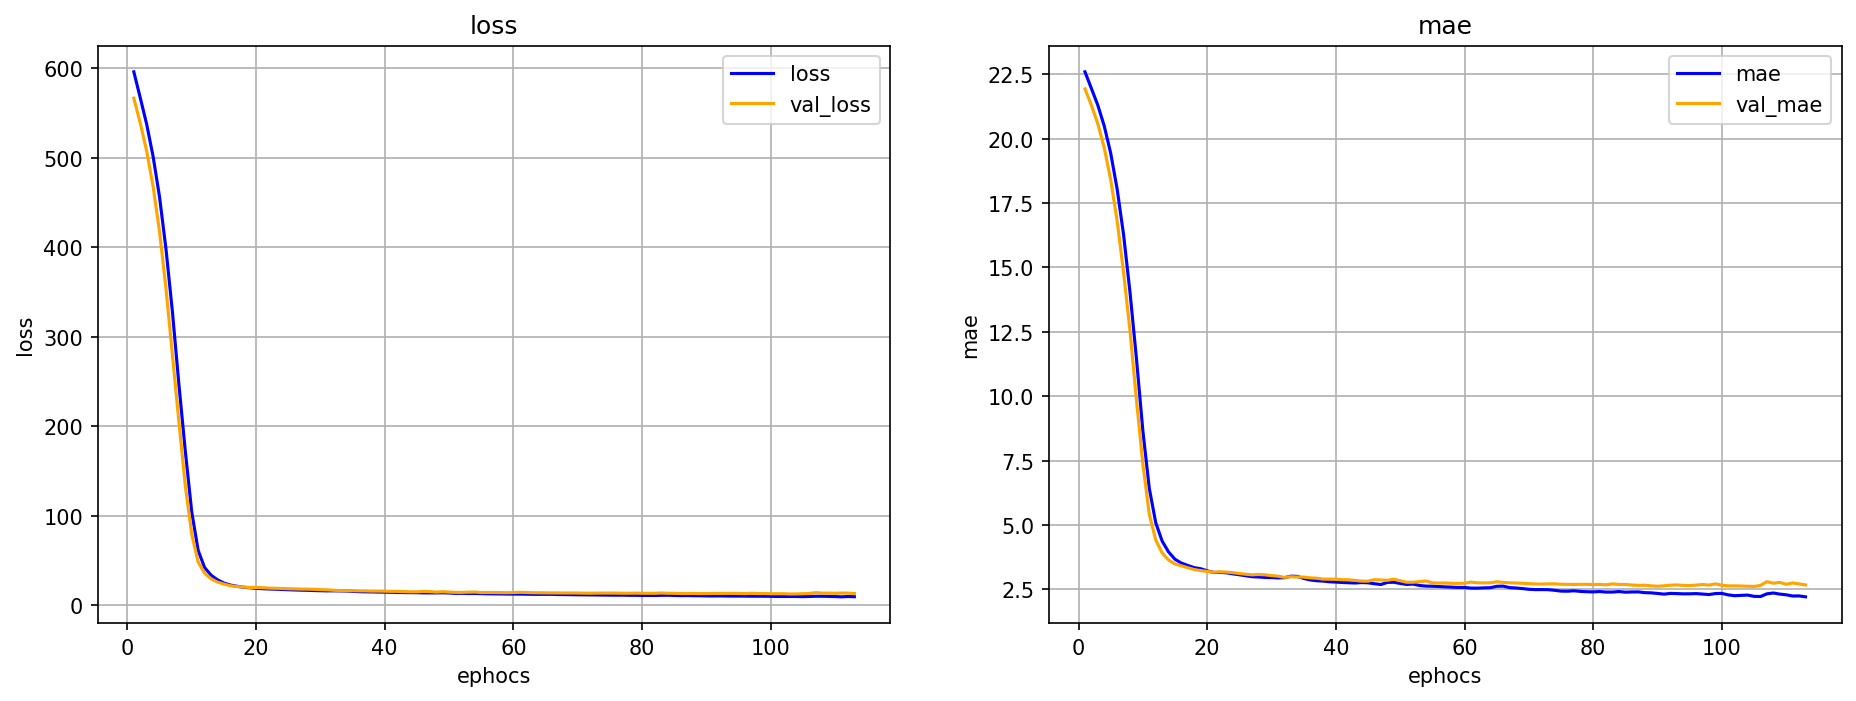

12/12 [==============================] - 0s 2ms/step - loss: 9.1864 - mae: 2.1924
최종 훈련 손실률: 9.186357, 최종 훈련 절대오차: 2.192388
5/5 [==============================] - 0s 2ms/step - loss: 12.9951 - mae: 2.6741
최종 검증 손실률: 12.995115, 최종 검증 절대오차: 2.674138


In [27]:
helper.tf_result_plot(result)

evaluate1 = model.evaluate(x_train, y_train)
print("최종 훈련 손실률: %f, 최종 훈련 절대오차: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test, y_test)
print("최종 검증 손실률: %f, 최종 검증 절대오차: %f" % (evaluate2[0], evaluate2[1]))

## #08. 학습 결과 적용

### 테스트 데이터에 대한 예측 결과 산정

In [28]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

5/5 [==============================] - 0s 1ms/step


### 결과 데이터 셋 구성

In [29]:
train_df = DataFrame(x_train, columns=x_train.columns)
train_df['관측치'] = y_train.values
train_df['예측치'] = train_pred.flatten()

train_df['훈련오차'] = train_df['관측치']-train_df['예측치']

train_df.head()

,CRIM,ZN,RM,AGE,RAD,PTRATIO,B,LSTAT,CHAS,CAT. MEDV,관측치,예측치,훈련오차
372,0.541569,-0.487722,-0.583589,0.747665,1.661245,0.806576,-0.096421,-0.528885,1,1,50.0,36.083130,13.916870
18,-0.327103,-0.487722,-1.180521,-1.137046,-0.637962,1.176466,-0.742112,-0.134996,0,0,20.2,18.090033,2.109967
185,-0.413480,-0.487722,-0.187534,0.008005,-0.752922,-0.303094,0.333711,0.069658,0,0,29.6,20.504917,9.095083
57,-0.418851,3.804234,0.757015,-0.998360,-0.523001,-1.551473,0.397194,-1.219941,0,1,31.6,33.589905,-1.989905
261,-0.358360,0.370669,1.759974,0.740552,-0.523001,-2.522434,0.347526,-0.755966,0,1,43.1,39.430023,3.669977


In [31]:
test_df = DataFrame(x_test, columns=x_train.columns)
test_df['관측치'] = y_test.values
test_df['예측치'] = test_pred.flatten()

test_df['훈련오차'] = test_df['관측치']-test_df['예측치']

test_df.head()

,CRIM,ZN,RM,AGE,RAD,PTRATIO,B,LSTAT,CHAS,CAT. MEDV,관측치,예측치,훈련오차
207,-0.391193,-0.487722,-0.714658,0.146691,-0.637962,0.066796,0.359148,0.757911,0,0,22.5,17.958916,4.541084
425,1.425197,-0.487722,-0.553671,0.953916,1.661245,0.806576,-3.826496,1.645211,0,0,8.3,12.021976,-3.721976
408,0.441097,-0.487722,-0.951151,1.042817,1.661245,0.806576,-0.460876,1.926960,0,0,17.2,10.346716,6.853284
63,-0.405796,0.585267,0.680083,-0.895234,-0.178120,0.575395,0.426579,-0.441977,0,0,25.0,20.905930,4.094070
290,-0.416442,2.945843,0.821124,-1.446423,-0.637962,0.344213,0.441052,-1.306849,0,0,28.5,26.966297,1.533703


### 실제 결과값과 머신러닝에 의한 예측값 비교

In [34]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.unicode_minus"] = False

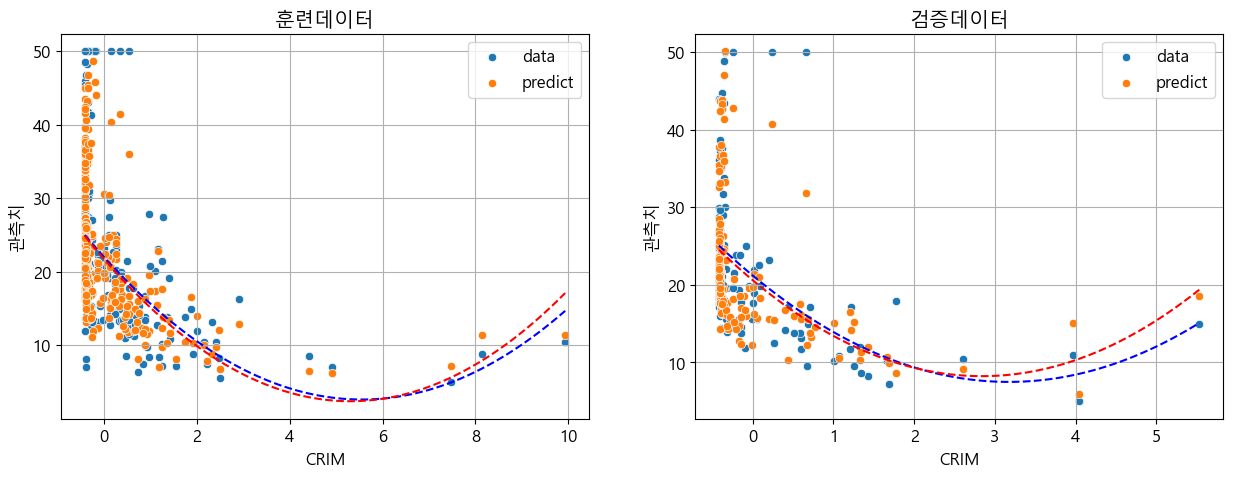

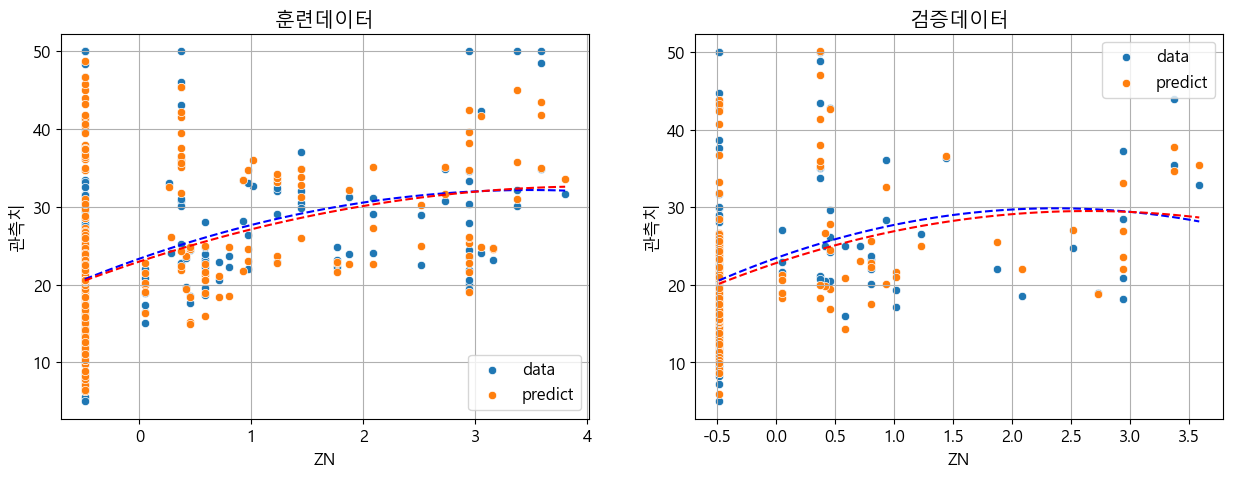

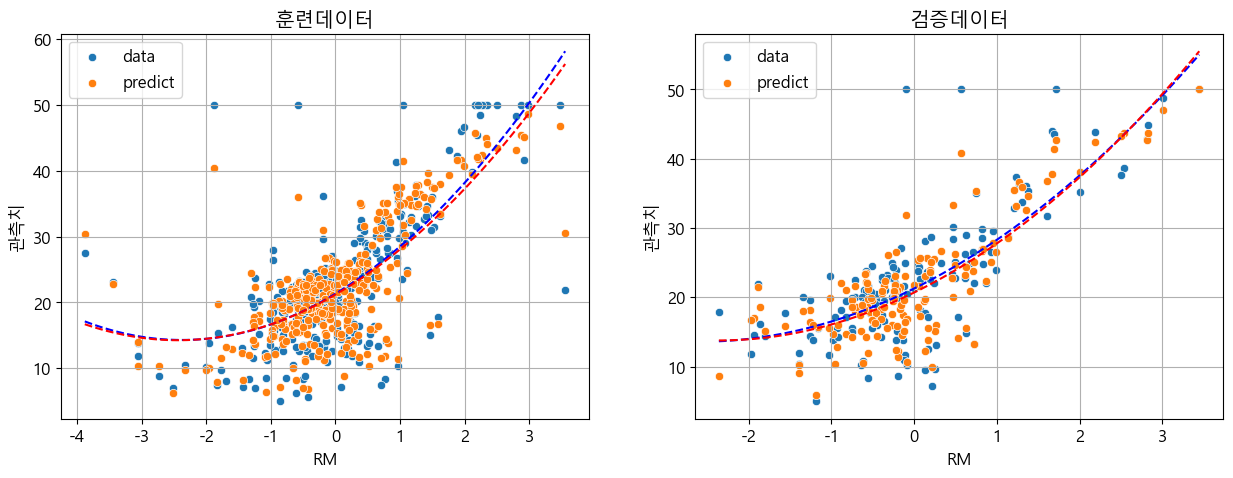

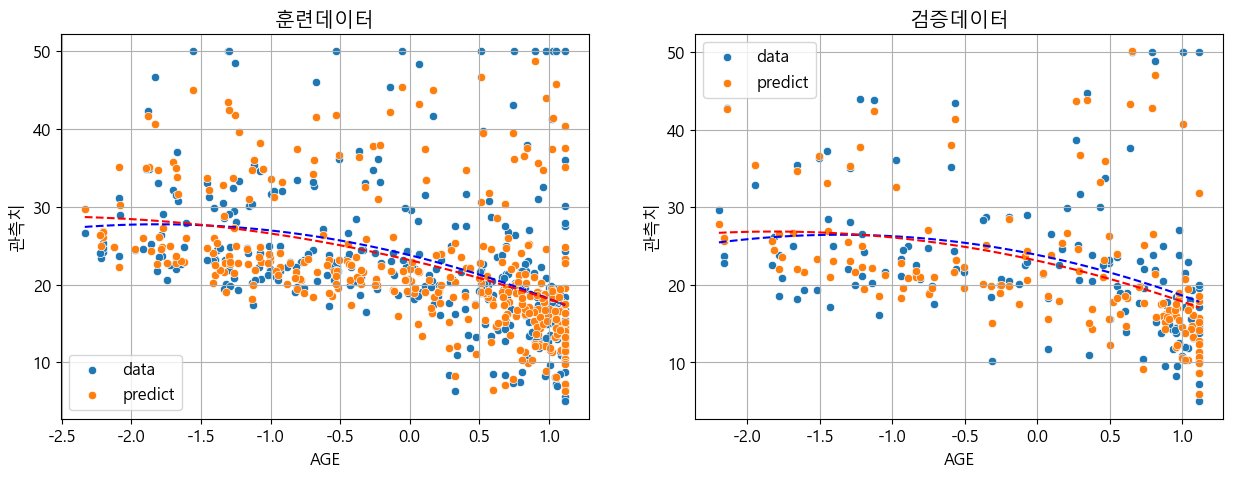

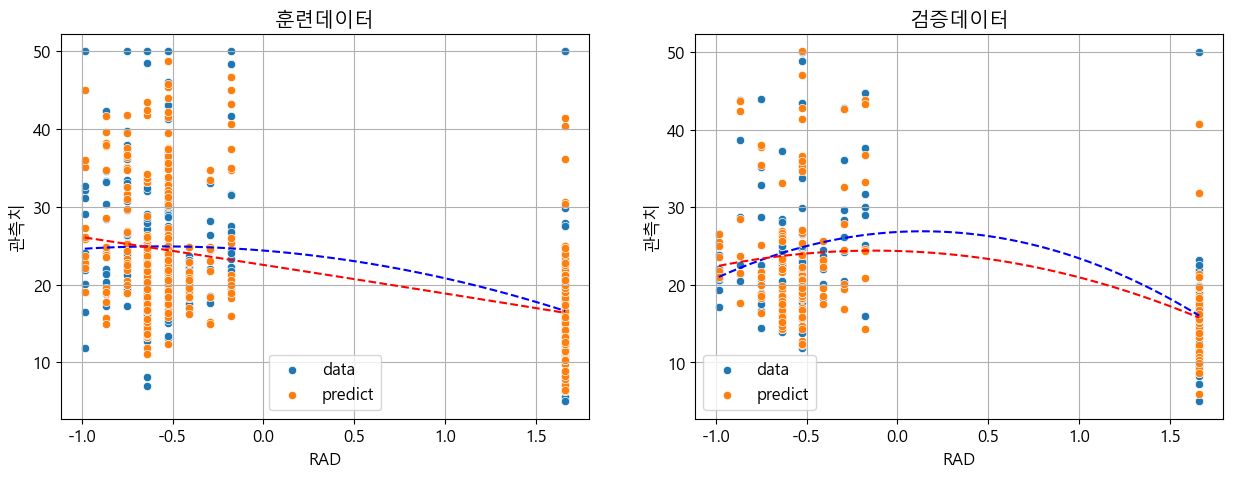

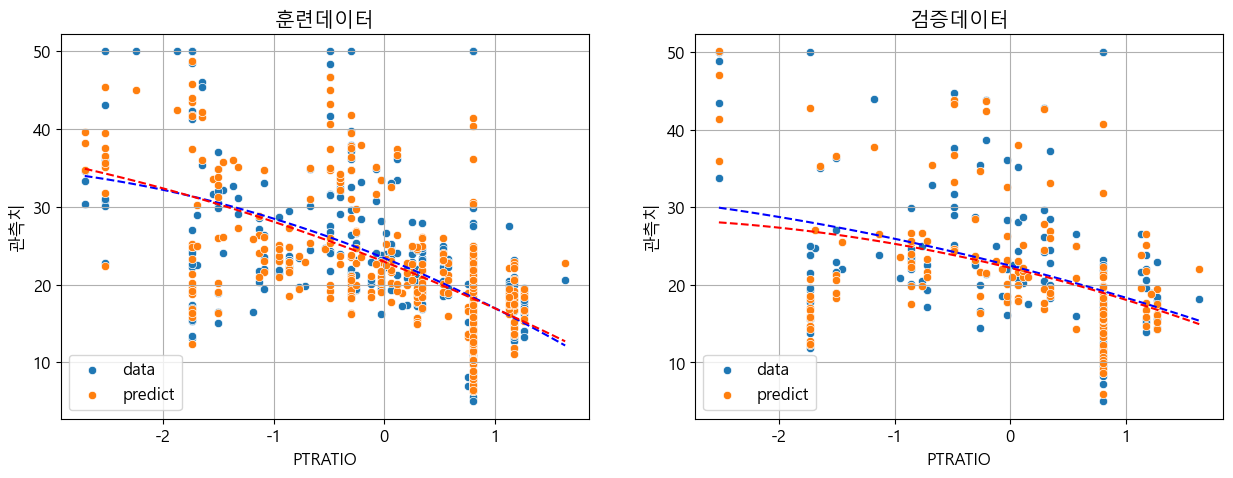

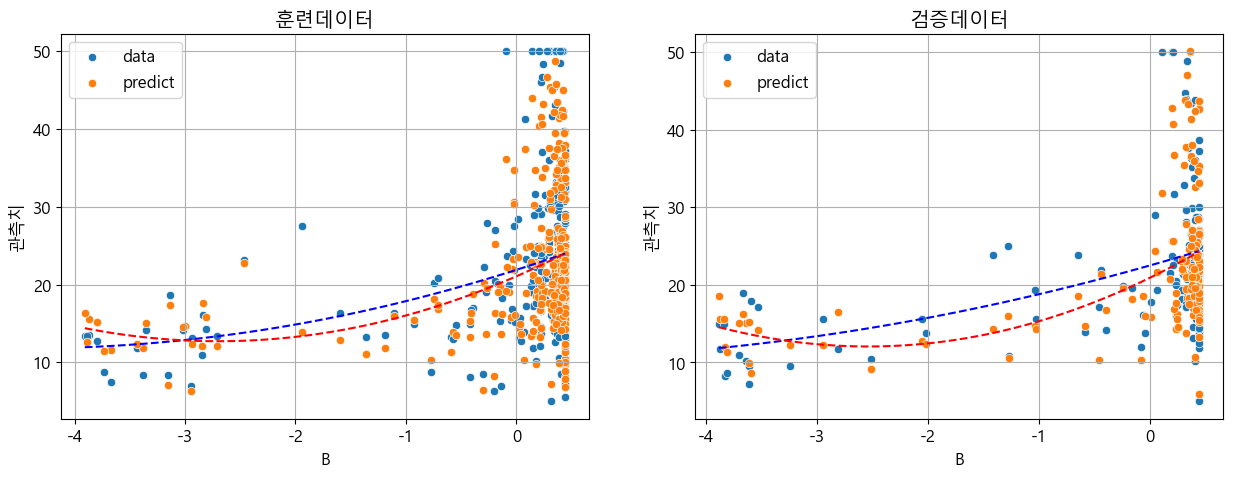

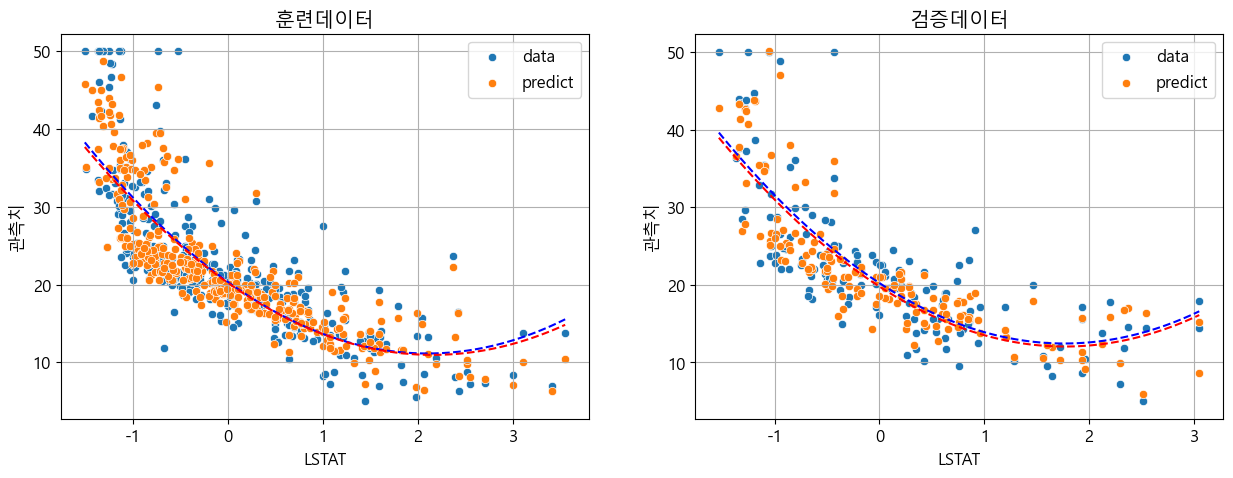

In [35]:
for key in ['CRIM','ZN','RM','AGE','RAD','PTRATIO','B','LSTAT']:
    helper.regplot(train_df[key], train_df['관측치'], train_df['예측치'], "훈련데이터",
                   test_df[key], test_df['관측치'], test_df['예측치'], "검증데이터",
                   figsize=(15, 5))